# Build CNN

## Loading image data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from skimage.transform import resize
#import cv2

from PIL import Image
import os
from shutil import copyfile

In [2]:
os.getcwd()
#os.chdir('/Users/qingruan/Desktop/九章算法项目课件/')

'/groups/dats6501/carrieqing'

In [3]:
category_names = [
'agricultural',
    'airplane', 'baseballdiamond', 'beach', 
    'buildings', 'chaparral', 'denseresidential', 'forest', 
    'freeway', 'golfcourse', 'harbor', 'intersection', 
    'mediumresidential', 'mobilehomepark', 
    'overpass', 'parkinglot', 'river', 'runway', 
    'sparseresidential', 'storagetanks', 'tenniscourt'
]

In [4]:
num_images = 100  # per category
nb_classes = len(category_names)
patch_size = 256  # width and height in pixel
channels = 3

In [5]:
# Load the numpy datasets
images_orig = np.load('new data/UCMerced_images_orig_MultiClass21.npy')
labels_num = np.load('new data/UCMerced_labels_num_MultiClass21.npy')

# Convert labels to categorical 'one hot encoded vector' --> required format for softmax cross-entropy loss.
# Create an array of zeros with length nb_classes and put a 1 at the index of the true label.
labels = to_categorical(labels_num, nb_classes)

print('Orginal Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels_num[i])

print('One-hot encoded Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels[i])

print('\nImages shape: {}'.format(images_orig.shape))
print('\nLabel shape: {}'.format(labels.shape))

Orginal Labels: 

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
One-hot encoded Labels: 

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 

In [6]:
nb_images = images_orig.shape[0]
nb_images

2100

## Train/val/test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images_orig, labels, 
                                                    test_size=0.2, 
                                                    stratify = labels, 
                                                    random_state=2021)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  stratify = y_train,
                                                  random_state=2021) 

# 0.25 x 0.8 = 0.2

In [8]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape,)

(1260, 64, 64, 3) (420, 64, 64, 3) (420, 64, 64, 3) (1260, 21) (420, 21) (420, 21)


Check how many images per class in train/val/test

In [9]:
def unique_counts(arr):
    unique, counts = np.unique(arr, axis=0, return_counts=True)
    unique_num = [np.where(r==1)[0][0] for r in unique] 
    print(dict(zip(unique_num, counts)))

In [10]:
unique_counts(y_train)
unique_counts(y_val)
unique_counts(y_test)

{20: 60, 19: 60, 18: 60, 17: 60, 16: 60, 15: 60, 14: 60, 13: 60, 12: 60, 11: 60, 10: 60, 9: 60, 8: 60, 7: 60, 6: 60, 5: 60, 4: 60, 3: 60, 2: 60, 1: 60, 0: 60}
{20: 20, 19: 20, 18: 20, 17: 20, 16: 20, 15: 20, 14: 20, 13: 20, 12: 20, 11: 20, 10: 20, 9: 20, 8: 20, 7: 20, 6: 20, 5: 20, 4: 20, 3: 20, 2: 20, 1: 20, 0: 20}
{20: 20, 19: 20, 18: 20, 17: 20, 16: 20, 15: 20, 14: 20, 13: 20, 12: 20, 11: 20, 10: 20, 9: 20, 8: 20, 7: 20, 6: 20, 5: 20, 4: 20, 3: 20, 2: 20, 1: 20, 0: 20}


## Building basic CNN

### [1] Build architecture

conv1: 32*(3,3) filter, same padding, relu + maxpooling; conv2: 64*(3,3) filter, same padding, relu + maxpooling
dropout 0.5
softmax

In [11]:
# parameters:
input_shape = (64, 64, 3)
pool_size = (2, 2)                  # size of pooling area for max pooling
prob_drop_hidden = 0.5              # drop probability for dropout @ dense layer

In [12]:
def define_CNN_Base():

    model = Sequential()

    # conv1 layer
    model.add(Conv2D(filters=32, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                     input_shape=input_shape))
    #model.add(BatchNormalization(momentum=0.9))
    model.add(Activation ('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
    
    # conv2 layer
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                     ))
    #model.add(BatchNormalization(momentum=0.9))
    model.add(Activation ('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
    
    # conv3 layer
    model.add(Conv2D(filters=128, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                     )) 
    #model.add(BatchNormalization(momentum=0.9))
    model.add(Activation ('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
    
    # conv4 layer
    model.add(Conv2D(filters=256, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                     )) 
    #model.add(BatchNormalization(momentum=0.9))
    model.add(Activation ('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    # conv5 layer
    model.add(Conv2D(filters=512, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                   ))    
    #model.add(BatchNormalization(momentum=0.9))
    model.add(Activation ('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Flatten())

    # fc1 layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))
    
    # fc2 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # The output of the model (softmax)
    model.add(Dense(21, activation='softmax'))
    return model

# clear the session first, such that layer names start with index 1
# clear the session first, such that layer names start with index 1
K.clear_session()
model = define_CNN_Base()

## data augmatation

In [13]:
# Data Generator provided by keras to load the training data in batches
image_gen = ImageDataGenerator(
    #zoom_range = 0.1,
    width_shift_range=5,   # pixel
    height_shift_range=5,  # pixel
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20)

# At Test/Validation time without data augmentation
image_gen_test = ImageDataGenerator()

train_gen = image_gen.flow(np.array(X_train),
                           y_train,
                           batch_size = 32,
                           shuffle = True)
val_gen = image_gen_test.flow(np.array(X_val),
                              y_val,
                              batch_size = 32,
                              shuffle = True)

## train model

In [14]:
def train_model(model, checkpoint_name):
    # Set hyper parameters
    epochs = 1000
    base_learning_rate=0.0001
    batch_size = 32
    batches_per_epoch = y_train.shape[0]//batch_size
    # the number of batches to see the full validation data:
    validation_steps = y_val.shape[0]//batch_size
    # Define an optimizer
    opt = Adam(lr=base_learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])       
    checkpoint_best_model = checkpoint_name

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=600)
    mc = ModelCheckpoint(checkpoint_best_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    # Fit the model parameters
    print('training base model...')

    history = model.fit(
                x=train_gen,
                steps_per_epoch=batches_per_epoch, 
                epochs=epochs, 
                validation_data=val_gen,
                validation_steps=validation_steps,
                callbacks=[es, mc],
                verbose = 2,
                )

    print('done')
    return model, history

Training commences by making a call to the fit method with our training and validation sets

In [15]:
checkpoint_best_model = 'model/MultiClass_5Conv2Dense.hdf5'
model, history = train_model(model, checkpoint_best_model)    

training base model...
Epoch 1/1000
39/39 - 11s - loss: 3.0461 - accuracy: 0.0432 - val_loss: 3.0379 - val_accuracy: 0.0481

Epoch 00001: val_accuracy improved from -inf to 0.04808, saving model to model/MultiClass_5Conv2Dense.hdf5
Epoch 2/1000
39/39 - 7s - loss: 3.0406 - accuracy: 0.0472 - val_loss: 3.0339 - val_accuracy: 0.0601

Epoch 00002: val_accuracy improved from 0.04808 to 0.06010, saving model to model/MultiClass_5Conv2Dense.hdf5
Epoch 3/1000
39/39 - 6s - loss: 3.0341 - accuracy: 0.0472 - val_loss: 3.0212 - val_accuracy: 0.0481

Epoch 00003: val_accuracy did not improve from 0.06010
Epoch 4/1000
39/39 - 6s - loss: 3.0189 - accuracy: 0.0480 - val_loss: 2.9681 - val_accuracy: 0.0649

Epoch 00004: val_accuracy improved from 0.06010 to 0.06490, saving model to model/MultiClass_5Conv2Dense.hdf5
Epoch 5/1000
39/39 - 6s - loss: 2.9661 - accuracy: 0.0643 - val_loss: 2.8888 - val_accuracy: 0.0745

Epoch 00005: val_accuracy improved from 0.06490 to 0.07452, saving model to model/MultiCl


Epoch 00046: val_accuracy did not improve from 0.52885
Epoch 47/1000
39/39 - 6s - loss: 1.6798 - accuracy: 0.4397 - val_loss: 1.9233 - val_accuracy: 0.4062

Epoch 00047: val_accuracy did not improve from 0.52885
Epoch 48/1000
39/39 - 6s - loss: 1.6413 - accuracy: 0.4552 - val_loss: 1.4553 - val_accuracy: 0.5240

Epoch 00048: val_accuracy did not improve from 0.52885
Epoch 49/1000
39/39 - 6s - loss: 1.6829 - accuracy: 0.4544 - val_loss: 1.5947 - val_accuracy: 0.5048

Epoch 00049: val_accuracy did not improve from 0.52885
Epoch 50/1000
39/39 - 6s - loss: 1.6615 - accuracy: 0.4634 - val_loss: 1.7862 - val_accuracy: 0.4375

Epoch 00050: val_accuracy did not improve from 0.52885
Epoch 51/1000
39/39 - 6s - loss: 1.6279 - accuracy: 0.4511 - val_loss: 1.4621 - val_accuracy: 0.5240

Epoch 00051: val_accuracy did not improve from 0.52885
Epoch 52/1000
39/39 - 6s - loss: 1.6068 - accuracy: 0.4796 - val_loss: 1.6267 - val_accuracy: 0.4736

Epoch 00052: val_accuracy did not improve from 0.52885
Ep

39/39 - 6s - loss: 1.0562 - accuracy: 0.6482 - val_loss: 1.0916 - val_accuracy: 0.6899

Epoch 00098: val_accuracy improved from 0.68750 to 0.68990, saving model to model/MultiClass_5Conv2Dense.hdf5
Epoch 99/1000
39/39 - 6s - loss: 1.0437 - accuracy: 0.6490 - val_loss: 1.3619 - val_accuracy: 0.6346

Epoch 00099: val_accuracy did not improve from 0.68990
Epoch 100/1000
39/39 - 6s - loss: 0.9881 - accuracy: 0.6694 - val_loss: 1.4459 - val_accuracy: 0.6010

Epoch 00100: val_accuracy did not improve from 0.68990
Epoch 101/1000
39/39 - 6s - loss: 1.0219 - accuracy: 0.6572 - val_loss: 1.3228 - val_accuracy: 0.6250

Epoch 00101: val_accuracy did not improve from 0.68990
Epoch 102/1000
39/39 - 6s - loss: 0.9991 - accuracy: 0.6482 - val_loss: 1.3226 - val_accuracy: 0.6418

Epoch 00102: val_accuracy did not improve from 0.68990
Epoch 103/1000
39/39 - 6s - loss: 0.9532 - accuracy: 0.6751 - val_loss: 1.4948 - val_accuracy: 0.6106

Epoch 00103: val_accuracy did not improve from 0.68990
Epoch 104/100


Epoch 00146: val_accuracy did not improve from 0.75000
Epoch 147/1000
39/39 - 6s - loss: 0.6441 - accuracy: 0.7834 - val_loss: 1.1365 - val_accuracy: 0.6995

Epoch 00147: val_accuracy did not improve from 0.75000
Epoch 148/1000
39/39 - 6s - loss: 0.6839 - accuracy: 0.7801 - val_loss: 1.0995 - val_accuracy: 0.7163

Epoch 00148: val_accuracy did not improve from 0.75000
Epoch 149/1000
39/39 - 6s - loss: 0.6784 - accuracy: 0.7647 - val_loss: 1.0959 - val_accuracy: 0.7139

Epoch 00149: val_accuracy did not improve from 0.75000
Epoch 150/1000
39/39 - 6s - loss: 0.6871 - accuracy: 0.7772 - val_loss: 1.0371 - val_accuracy: 0.7332

Epoch 00150: val_accuracy did not improve from 0.75000
Epoch 151/1000
39/39 - 6s - loss: 0.6000 - accuracy: 0.8078 - val_loss: 1.0289 - val_accuracy: 0.7380

Epoch 00151: val_accuracy did not improve from 0.75000
Epoch 152/1000
39/39 - 6s - loss: 0.6194 - accuracy: 0.7923 - val_loss: 0.9433 - val_accuracy: 0.7404

Epoch 00152: val_accuracy did not improve from 0.75


Epoch 00197: val_accuracy did not improve from 0.77644
Epoch 198/1000
39/39 - 6s - loss: 0.3807 - accuracy: 0.8762 - val_loss: 1.1682 - val_accuracy: 0.7308

Epoch 00198: val_accuracy did not improve from 0.77644
Epoch 199/1000
39/39 - 6s - loss: 0.4552 - accuracy: 0.8526 - val_loss: 1.0650 - val_accuracy: 0.7308

Epoch 00199: val_accuracy did not improve from 0.77644
Epoch 200/1000
39/39 - 7s - loss: 0.4501 - accuracy: 0.8583 - val_loss: 0.9959 - val_accuracy: 0.7620

Epoch 00200: val_accuracy did not improve from 0.77644
Epoch 201/1000
39/39 - 6s - loss: 0.4217 - accuracy: 0.8795 - val_loss: 1.1270 - val_accuracy: 0.7428

Epoch 00201: val_accuracy did not improve from 0.77644
Epoch 202/1000
39/39 - 6s - loss: 0.4046 - accuracy: 0.8721 - val_loss: 1.2890 - val_accuracy: 0.7115

Epoch 00202: val_accuracy did not improve from 0.77644
Epoch 203/1000
39/39 - 6s - loss: 0.3787 - accuracy: 0.8754 - val_loss: 1.0040 - val_accuracy: 0.7596

Epoch 00203: val_accuracy did not improve from 0.77


Epoch 00248: val_accuracy did not improve from 0.82452
Epoch 249/1000
39/39 - 6s - loss: 0.2269 - accuracy: 0.9357 - val_loss: 1.0476 - val_accuracy: 0.7668

Epoch 00249: val_accuracy did not improve from 0.82452
Epoch 250/1000
39/39 - 6s - loss: 0.2234 - accuracy: 0.9226 - val_loss: 1.1419 - val_accuracy: 0.7716

Epoch 00250: val_accuracy did not improve from 0.82452
Epoch 251/1000
39/39 - 6s - loss: 0.2510 - accuracy: 0.9226 - val_loss: 1.0799 - val_accuracy: 0.7837

Epoch 00251: val_accuracy did not improve from 0.82452
Epoch 252/1000
39/39 - 6s - loss: 0.2624 - accuracy: 0.9153 - val_loss: 0.9157 - val_accuracy: 0.7957

Epoch 00252: val_accuracy did not improve from 0.82452
Epoch 253/1000
39/39 - 6s - loss: 0.2412 - accuracy: 0.9267 - val_loss: 0.9629 - val_accuracy: 0.7981

Epoch 00253: val_accuracy did not improve from 0.82452
Epoch 254/1000
39/39 - 6s - loss: 0.2736 - accuracy: 0.9218 - val_loss: 1.1625 - val_accuracy: 0.7596

Epoch 00254: val_accuracy did not improve from 0.82


Epoch 00300: val_accuracy did not improve from 0.83413
Epoch 301/1000
39/39 - 6s - loss: 0.1465 - accuracy: 0.9544 - val_loss: 1.1324 - val_accuracy: 0.7812

Epoch 00301: val_accuracy did not improve from 0.83413
Epoch 302/1000
39/39 - 6s - loss: 0.1692 - accuracy: 0.9463 - val_loss: 1.1783 - val_accuracy: 0.7740

Epoch 00302: val_accuracy did not improve from 0.83413
Epoch 303/1000
39/39 - 6s - loss: 0.1818 - accuracy: 0.9454 - val_loss: 1.2863 - val_accuracy: 0.7452

Epoch 00303: val_accuracy did not improve from 0.83413
Epoch 304/1000
39/39 - 6s - loss: 0.1813 - accuracy: 0.9471 - val_loss: 1.1878 - val_accuracy: 0.7524

Epoch 00304: val_accuracy did not improve from 0.83413
Epoch 305/1000
39/39 - 6s - loss: 0.1785 - accuracy: 0.9446 - val_loss: 1.3925 - val_accuracy: 0.7668

Epoch 00305: val_accuracy did not improve from 0.83413
Epoch 306/1000
39/39 - 7s - loss: 0.1807 - accuracy: 0.9487 - val_loss: 1.0853 - val_accuracy: 0.7909

Epoch 00306: val_accuracy did not improve from 0.83


Epoch 00352: val_accuracy did not improve from 0.83413
Epoch 353/1000
39/39 - 6s - loss: 0.1067 - accuracy: 0.9634 - val_loss: 1.0484 - val_accuracy: 0.7885

Epoch 00353: val_accuracy did not improve from 0.83413
Epoch 354/1000
39/39 - 6s - loss: 0.0931 - accuracy: 0.9739 - val_loss: 1.1880 - val_accuracy: 0.7933

Epoch 00354: val_accuracy did not improve from 0.83413
Epoch 355/1000
39/39 - 6s - loss: 0.1040 - accuracy: 0.9748 - val_loss: 1.2350 - val_accuracy: 0.7788

Epoch 00355: val_accuracy did not improve from 0.83413
Epoch 356/1000
39/39 - 6s - loss: 0.1190 - accuracy: 0.9634 - val_loss: 1.1675 - val_accuracy: 0.7885

Epoch 00356: val_accuracy did not improve from 0.83413
Epoch 357/1000
39/39 - 6s - loss: 0.1263 - accuracy: 0.9593 - val_loss: 1.0005 - val_accuracy: 0.8077

Epoch 00357: val_accuracy did not improve from 0.83413
Epoch 358/1000
39/39 - 6s - loss: 0.1288 - accuracy: 0.9601 - val_loss: 1.0575 - val_accuracy: 0.7861

Epoch 00358: val_accuracy did not improve from 0.83


Epoch 00404: val_accuracy did not improve from 0.83413
Epoch 405/1000
39/39 - 6s - loss: 0.0878 - accuracy: 0.9731 - val_loss: 1.0683 - val_accuracy: 0.7837

Epoch 00405: val_accuracy did not improve from 0.83413
Epoch 406/1000
39/39 - 6s - loss: 0.0954 - accuracy: 0.9739 - val_loss: 0.9870 - val_accuracy: 0.8149

Epoch 00406: val_accuracy did not improve from 0.83413
Epoch 407/1000
39/39 - 6s - loss: 0.0871 - accuracy: 0.9764 - val_loss: 0.9178 - val_accuracy: 0.8293

Epoch 00407: val_accuracy did not improve from 0.83413
Epoch 408/1000
39/39 - 6s - loss: 0.1667 - accuracy: 0.9625 - val_loss: 1.2997 - val_accuracy: 0.7572

Epoch 00408: val_accuracy did not improve from 0.83413
Epoch 409/1000
39/39 - 6s - loss: 0.1189 - accuracy: 0.9617 - val_loss: 0.9477 - val_accuracy: 0.7981

Epoch 00409: val_accuracy did not improve from 0.83413
Epoch 410/1000
39/39 - 6s - loss: 0.0586 - accuracy: 0.9845 - val_loss: 1.0137 - val_accuracy: 0.8101

Epoch 00410: val_accuracy did not improve from 0.83


Epoch 00456: val_accuracy did not improve from 0.85096
Epoch 457/1000
39/39 - 6s - loss: 0.0448 - accuracy: 0.9902 - val_loss: 1.1560 - val_accuracy: 0.7933

Epoch 00457: val_accuracy did not improve from 0.85096
Epoch 458/1000
39/39 - 6s - loss: 0.0683 - accuracy: 0.9821 - val_loss: 1.3782 - val_accuracy: 0.7764

Epoch 00458: val_accuracy did not improve from 0.85096
Epoch 459/1000
39/39 - 6s - loss: 0.1014 - accuracy: 0.9723 - val_loss: 1.2786 - val_accuracy: 0.7740

Epoch 00459: val_accuracy did not improve from 0.85096
Epoch 460/1000
39/39 - 6s - loss: 0.1110 - accuracy: 0.9658 - val_loss: 1.1476 - val_accuracy: 0.7957

Epoch 00460: val_accuracy did not improve from 0.85096
Epoch 461/1000
39/39 - 6s - loss: 0.0637 - accuracy: 0.9813 - val_loss: 1.4789 - val_accuracy: 0.7740

Epoch 00461: val_accuracy did not improve from 0.85096
Epoch 462/1000
39/39 - 6s - loss: 0.0776 - accuracy: 0.9796 - val_loss: 0.9943 - val_accuracy: 0.8245

Epoch 00462: val_accuracy did not improve from 0.85


Epoch 00508: val_accuracy did not improve from 0.85096
Epoch 509/1000
39/39 - 6s - loss: 0.0723 - accuracy: 0.9772 - val_loss: 1.0218 - val_accuracy: 0.8245

Epoch 00509: val_accuracy did not improve from 0.85096
Epoch 510/1000
39/39 - 6s - loss: 0.0607 - accuracy: 0.9796 - val_loss: 0.8636 - val_accuracy: 0.8534

Epoch 00510: val_accuracy improved from 0.85096 to 0.85337, saving model to model/MultiClass_5Conv2Dense.hdf5
Epoch 511/1000
39/39 - 6s - loss: 0.0525 - accuracy: 0.9862 - val_loss: 1.0721 - val_accuracy: 0.8005

Epoch 00511: val_accuracy did not improve from 0.85337
Epoch 512/1000
39/39 - 6s - loss: 0.0472 - accuracy: 0.9862 - val_loss: 1.3147 - val_accuracy: 0.8029

Epoch 00512: val_accuracy did not improve from 0.85337
Epoch 513/1000
39/39 - 6s - loss: 0.0427 - accuracy: 0.9886 - val_loss: 1.2011 - val_accuracy: 0.7861

Epoch 00513: val_accuracy did not improve from 0.85337
Epoch 514/1000
39/39 - 6s - loss: 0.0262 - accuracy: 0.9910 - val_loss: 1.3379 - val_accuracy: 0.77


Epoch 00560: val_accuracy did not improve from 0.85337
Epoch 561/1000
39/39 - 5s - loss: 0.0273 - accuracy: 0.9935 - val_loss: 1.0823 - val_accuracy: 0.8317

Epoch 00561: val_accuracy did not improve from 0.85337
Epoch 562/1000
39/39 - 5s - loss: 0.0403 - accuracy: 0.9864 - val_loss: 1.2486 - val_accuracy: 0.7933

Epoch 00562: val_accuracy did not improve from 0.85337
Epoch 563/1000
39/39 - 5s - loss: 0.0338 - accuracy: 0.9927 - val_loss: 1.0495 - val_accuracy: 0.8245

Epoch 00563: val_accuracy did not improve from 0.85337
Epoch 564/1000
39/39 - 5s - loss: 0.0564 - accuracy: 0.9821 - val_loss: 1.0975 - val_accuracy: 0.8125

Epoch 00564: val_accuracy did not improve from 0.85337
Epoch 565/1000
39/39 - 5s - loss: 0.0547 - accuracy: 0.9853 - val_loss: 1.2258 - val_accuracy: 0.7909

Epoch 00565: val_accuracy did not improve from 0.85337
Epoch 566/1000
39/39 - 5s - loss: 0.0636 - accuracy: 0.9821 - val_loss: 1.0298 - val_accuracy: 0.8341

Epoch 00566: val_accuracy did not improve from 0.85


Epoch 00612: val_accuracy did not improve from 0.85337
Epoch 613/1000
39/39 - 5s - loss: 0.0201 - accuracy: 0.9927 - val_loss: 1.0843 - val_accuracy: 0.8173

Epoch 00613: val_accuracy did not improve from 0.85337
Epoch 614/1000
39/39 - 5s - loss: 0.0248 - accuracy: 0.9935 - val_loss: 1.2755 - val_accuracy: 0.8125

Epoch 00614: val_accuracy did not improve from 0.85337
Epoch 615/1000
39/39 - 4s - loss: 0.0264 - accuracy: 0.9919 - val_loss: 1.1874 - val_accuracy: 0.8173

Epoch 00615: val_accuracy did not improve from 0.85337
Epoch 616/1000
39/39 - 4s - loss: 0.0346 - accuracy: 0.9927 - val_loss: 1.2253 - val_accuracy: 0.7981

Epoch 00616: val_accuracy did not improve from 0.85337
Epoch 617/1000
39/39 - 4s - loss: 0.0603 - accuracy: 0.9813 - val_loss: 1.5303 - val_accuracy: 0.7812

Epoch 00617: val_accuracy did not improve from 0.85337
Epoch 618/1000
39/39 - 4s - loss: 0.0888 - accuracy: 0.9756 - val_loss: 1.3258 - val_accuracy: 0.8077

Epoch 00618: val_accuracy did not improve from 0.85


Epoch 00664: val_accuracy did not improve from 0.85337
Epoch 665/1000
39/39 - 4s - loss: 0.0402 - accuracy: 0.9910 - val_loss: 1.1015 - val_accuracy: 0.8197

Epoch 00665: val_accuracy did not improve from 0.85337
Epoch 666/1000
39/39 - 4s - loss: 0.0233 - accuracy: 0.9902 - val_loss: 1.2165 - val_accuracy: 0.8029

Epoch 00666: val_accuracy did not improve from 0.85337
Epoch 667/1000
39/39 - 4s - loss: 0.0412 - accuracy: 0.9902 - val_loss: 1.6870 - val_accuracy: 0.7861

Epoch 00667: val_accuracy did not improve from 0.85337
Epoch 668/1000
39/39 - 4s - loss: 0.1199 - accuracy: 0.9666 - val_loss: 1.1715 - val_accuracy: 0.8173

Epoch 00668: val_accuracy did not improve from 0.85337
Epoch 669/1000
39/39 - 5s - loss: 0.0443 - accuracy: 0.9862 - val_loss: 1.0048 - val_accuracy: 0.8173

Epoch 00669: val_accuracy did not improve from 0.85337
Epoch 670/1000
39/39 - 4s - loss: 0.0225 - accuracy: 0.9935 - val_loss: 1.0177 - val_accuracy: 0.8317

Epoch 00670: val_accuracy did not improve from 0.85


Epoch 00716: val_accuracy did not improve from 0.85577
Epoch 717/1000
39/39 - 4s - loss: 0.1330 - accuracy: 0.9674 - val_loss: 1.3150 - val_accuracy: 0.8101

Epoch 00717: val_accuracy did not improve from 0.85577
Epoch 718/1000
39/39 - 4s - loss: 0.0832 - accuracy: 0.9764 - val_loss: 0.9461 - val_accuracy: 0.8293

Epoch 00718: val_accuracy did not improve from 0.85577
Epoch 719/1000
39/39 - 4s - loss: 0.0302 - accuracy: 0.9894 - val_loss: 1.0263 - val_accuracy: 0.8197

Epoch 00719: val_accuracy did not improve from 0.85577
Epoch 720/1000
39/39 - 4s - loss: 0.0286 - accuracy: 0.9943 - val_loss: 0.9059 - val_accuracy: 0.8317

Epoch 00720: val_accuracy did not improve from 0.85577
Epoch 721/1000
39/39 - 4s - loss: 0.0127 - accuracy: 0.9967 - val_loss: 0.9324 - val_accuracy: 0.8389

Epoch 00721: val_accuracy did not improve from 0.85577
Epoch 722/1000
39/39 - 4s - loss: 0.0224 - accuracy: 0.9910 - val_loss: 1.0019 - val_accuracy: 0.8438

Epoch 00722: val_accuracy did not improve from 0.85


Epoch 00768: val_accuracy did not improve from 0.86298
Epoch 769/1000
39/39 - 4s - loss: 0.0257 - accuracy: 0.9927 - val_loss: 1.3663 - val_accuracy: 0.7933

Epoch 00769: val_accuracy did not improve from 0.86298
Epoch 770/1000
39/39 - 4s - loss: 0.0540 - accuracy: 0.9894 - val_loss: 0.9029 - val_accuracy: 0.8510

Epoch 00770: val_accuracy did not improve from 0.86298
Epoch 771/1000
39/39 - 4s - loss: 0.0455 - accuracy: 0.9902 - val_loss: 0.8809 - val_accuracy: 0.8558

Epoch 00771: val_accuracy did not improve from 0.86298
Epoch 772/1000
39/39 - 4s - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.9781 - val_accuracy: 0.8389

Epoch 00772: val_accuracy did not improve from 0.86298
Epoch 773/1000
39/39 - 4s - loss: 0.0183 - accuracy: 0.9943 - val_loss: 1.0841 - val_accuracy: 0.8245

Epoch 00773: val_accuracy did not improve from 0.86298
Epoch 774/1000
39/39 - 4s - loss: 0.0176 - accuracy: 0.9951 - val_loss: 1.0980 - val_accuracy: 0.8389

Epoch 00774: val_accuracy did not improve from 0.86


Epoch 00820: val_accuracy did not improve from 0.86298
Epoch 821/1000
39/39 - 4s - loss: 0.0254 - accuracy: 0.9935 - val_loss: 1.0267 - val_accuracy: 0.8365

Epoch 00821: val_accuracy did not improve from 0.86298
Epoch 822/1000
39/39 - 4s - loss: 0.0267 - accuracy: 0.9935 - val_loss: 1.1104 - val_accuracy: 0.8221

Epoch 00822: val_accuracy did not improve from 0.86298
Epoch 823/1000
39/39 - 4s - loss: 0.0062 - accuracy: 0.9992 - val_loss: 1.1297 - val_accuracy: 0.8245

Epoch 00823: val_accuracy did not improve from 0.86298
Epoch 824/1000
39/39 - 4s - loss: 0.0126 - accuracy: 0.9959 - val_loss: 1.2777 - val_accuracy: 0.8101

Epoch 00824: val_accuracy did not improve from 0.86298
Epoch 825/1000
39/39 - 4s - loss: 0.0178 - accuracy: 0.9943 - val_loss: 1.1870 - val_accuracy: 0.8413

Epoch 00825: val_accuracy did not improve from 0.86298
Epoch 826/1000
39/39 - 4s - loss: 0.0260 - accuracy: 0.9943 - val_loss: 1.1514 - val_accuracy: 0.8365

Epoch 00826: val_accuracy did not improve from 0.86


Epoch 00872: val_accuracy did not improve from 0.86298
Epoch 873/1000
39/39 - 4s - loss: 0.0164 - accuracy: 0.9951 - val_loss: 1.2437 - val_accuracy: 0.8269

Epoch 00873: val_accuracy did not improve from 0.86298
Epoch 874/1000
39/39 - 4s - loss: 0.0286 - accuracy: 0.9935 - val_loss: 1.2800 - val_accuracy: 0.8101

Epoch 00874: val_accuracy did not improve from 0.86298
Epoch 875/1000
39/39 - 4s - loss: 0.0166 - accuracy: 0.9976 - val_loss: 0.9848 - val_accuracy: 0.8462

Epoch 00875: val_accuracy did not improve from 0.86298
Epoch 876/1000
39/39 - 4s - loss: 0.0169 - accuracy: 0.9967 - val_loss: 1.3953 - val_accuracy: 0.7981

Epoch 00876: val_accuracy did not improve from 0.86298
Epoch 877/1000
39/39 - 4s - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.9634 - val_accuracy: 0.8462

Epoch 00877: val_accuracy did not improve from 0.86298
Epoch 878/1000
39/39 - 4s - loss: 0.0104 - accuracy: 0.9976 - val_loss: 1.1200 - val_accuracy: 0.8389

Epoch 00878: val_accuracy did not improve from 0.86

Plotting training accuracy/loss curves

In [16]:
def history_plot(model_id, history):
	plt.figure(figsize=(8,10)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.xlabel("Epochs", fontsize = 120)
	plt.ylabel("Accuracy", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

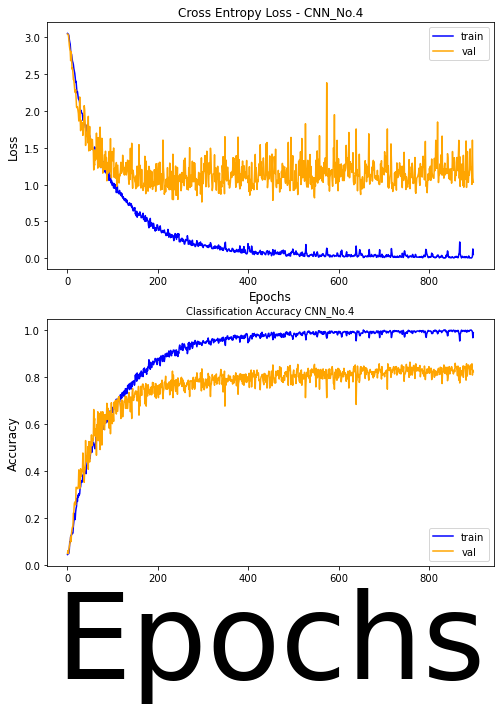

In [17]:
history_plot('CNN_No.4', history)

#### Saving our model to disk

A Keras model consists of multiple components:

+ An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
+ A set of weights values (the "state of the model").
+ An optimizer (defined by compiling the model).
+ A set of losses and metrics (defined by compiling the model or calling add_loss() or add_metric()).
The Keras API makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:

+ Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice.
+ Saving the architecture / configuration only, typically as a JSON file.
+ Saving the weights values only. This is generally used when training the model.

In [18]:
saved_model = load_model(checkpoint_best_model)

from datetime import datetime
DTime = datetime.now().strftime('%Y%m%d_%H%M%S')

_, acc = saved_model.evaluate(X_train, y_train, verbose=0)
print('Model evaluate on train, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_val, y_val, verbose=0)
print('Model evaluate on val, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))
acc_test = round(100*acc,2)

save_file = checkpoint_best_model[0:-5] +'_' + DTime + '_ACC' + str(acc_test)+'.h5'
print("Model saved: ", save_file)
saved_model.save(save_file,  save_format="h5")

Model evaluate on train, Accuracy 100.000
Model evaluate on val, Accuracy 86.190
Model evaluate on test, Accuracy 83.571
Model saved:  model/MultiClass_5Conv2Dense_20210227_012654_ACC83.57.h5


### Predict test data